In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import LGTp as lgt

# Review of Extending machine learning classification capabilities with histogram reweighting  
  
ref : [Bachtis, Aarts, Lucini, Phys. Rev. E 102, 033303](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.102.033303)

This note is to review and reproduce phase detection using machine learning with histogram reweighting.  It will be done by following procedure.  
1. We define Ising model action and generate Ising model configurations using Wolff algorithm for traning and validation.  
2. Build CNN layers proposed in the ref and train using the Ising model configurations
3. Summarize about histogram reweighting and apply it to CNN output

In [2]:
# General parameters
seed = 1234
ensemble_size = 1000
N = 16

# 0. Observables

* Ising model energy
\begin{equation}
E = -J\sum_{i,j \in nn} \sigma_{i} \sigma_{j} + \mu h \sum_{i \in \Lambda} \sigma_{i}
\end{equation}

In [3]:
def calcEnergy(config):
    """Calculate energy density
    """
    energy = 0
    
    for i in range(len(config)):
        for j in range(len(config)):
            s = config[i,j]
            nn = config[(i+1)%N,j] \
            + config[(i-1)%N,j] \
            + config[i,(j+1)%N] \
            + config[i,(j-1)%N]
            energy += -nn*s
    return energy*0.5/len(config)/len(config)

def calcMag(config):
    """Calculate magnetization
    """
    mag = np.average(config)
    return mag

def calcAbsMag(config):
    """Calculate absolute value of magnetization
    """
    mag = np.abs(np.average(config))
    return mag

## 1. Autocorrelation test

### 1-1. Hot - Cold initialization

In [4]:
# Generate lattice
ising_cold = lgt.Lattice([N,N])
ising_cold.init_fields('Ising2d','Cold',seed)

ising_hot = lgt.Lattice([N,N])
ising_hot.init_fields('Ising2d','Hot',seed)

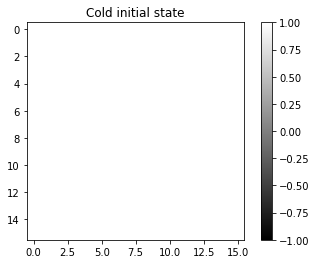

In [5]:
plt.title("Cold initial state")
plt.imshow(ising_cold.field,cmap='gray',vmin=-1,vmax=1)
plt.colorbar()

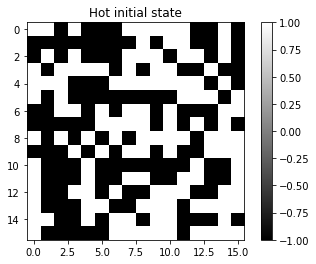

In [6]:
plt.title("Hot initial state")
plt.imshow(ising_hot.field,cmap='gray',vmin=-1,vmax=1)
plt.colorbar()

In [7]:
# Input paramters
T = np.linspace(1.53,3.28,32)
bare_parameters = {'beta':1./T[1], 'J':1., 'h':0.00, 'mu':0.1}

In [8]:
def detect_equi_t(O_cold, O_hot, tol = 1e-1, step = 20):
    
    t = len(O_cold)
    
    for i in range(len(O_cold)-step):
        
        diff = np.abs(np.average(np.abs(O_cold[i:i+step]) - np.abs(O_hot[i:i+step])))
        
        if diff < tol:
            t = i
            return t
    
    return t

In [9]:
# Equilibrating phase detection
def calc_teq(bare_arg, O, tol=5e-2, step=1000,seed=0):
    t_eq = step

    O_cold = []
    O_hot = []

    ising_cold = lgt.Lattice([N,N])
    ising_cold.init_fields('Ising2d','Cold',seed)

    ising_hot = lgt.Lattice([N,N])
    ising_hot.init_fields('Ising2d','Hot',seed)
    
    for i in range(step):
        lgt.metropolis(ising_cold,bare_arg)
        lgt.metropolis(ising_hot,bare_arg)

        diff = np.abs(O(ising_cold.field) - O(ising_hot.field))
        O_cold.append(O(ising_cold.field))
        O_hot.append(O(ising_hot.field))

        if diff < tol:
            t_eq = i
            break

    plt.title("Estimation of autocorrelation time")
    plt.plot(np.arange(t_eq+1),O_cold,'C0',label='cold')
    plt.plot(np.arange(t_eq+1),O_hot,'C3',label='hot')
    plt.legend(loc='upper right')
    plt.xlabel("Monte Carlo time")
    plt.ylabel("Observable")
    plt.grid(True)
    plt.show()
    
    return t_eq

In [10]:
ising_cold.lat_size

256

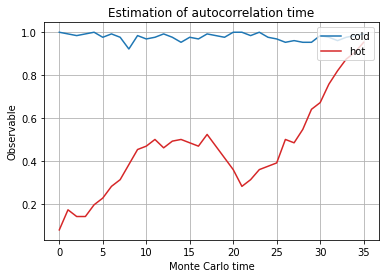

35


In [11]:
t_eq = calc_teq(bare_parameters,calcAbsMag,seed)
print(t_eq)

### 1-2. Autocorrelation function

In [17]:
def autocorrelation(conf, O, t):
    
    N = len(conf) - t
    
#     cor_hist = np.empty(N)
    
    o1o2 = 0.
    o1 = 0.
    o2 = 0.
    
    o1o1 = 0.
    o2o2 = 0.
    
    for i in range(N):
        
        o1o2 += O(conf[i])*O(conf[i+t])/N
        
        o1 += O(conf[i])/N
        o2 += O(conf[i+t])/N
        
        o1o1 += O(conf[i])*O(conf[i])/N
        o2o2 += O(conf[i+t])*O(conf[i+t])/N
        
    o1_err = np.sqrt(o1o1 - o1*o1)
    o2_err = np.sqrt(o2o2 - o2*o2)
        
    cor_t = o1o2 - o1*o2
        
    return cor_t/o1_err/o2_err

In [18]:
def detect_ac_t(ac, tol = 5e-2, step = 3):
    
    t = len(ac)
    
    for i in range(len(ac) - step):
        
        diff = np.average(np.abs(ac[i:i+step]))
        
        if diff < tol:
            t = i
            return t
    
    return t

In [19]:
# Generate lattice
ising_ac = lgt.Lattice([N,N])
ising_ac.init_fields('Ising2d','Cold')

In [20]:
# Input paramters
T = np.linspace(1.53,3.28,32)
bare_parameters = {'beta':1./T[0], 'J':1., 'h':0.00, 'mu':0.1}

In [21]:
n_equi_ac = t_eq
for i in range(n_equi_ac):
    lgt.metropolis(ising_ac, bare_parameters)

n_conf_ac = 100
conf_ac = []
M_ac = []
for e in range(n_conf_ac):
    lgt.metropolis(ising_ac,bare_parameters)
    conf_ac.append(ising_ac.field)
    Mag = calcMag(ising_ac.field)
    M_ac.append(Mag)

In [22]:
np.shape(conf_ac)

(100, 16, 16)

In [23]:
# Calculate autocorrelation
ac_hist = np.empty(len(conf_ac))

for i in range(len(conf_ac)):
    ac_hist[i] = autocorrelation(conf_ac,calcAbsMag,i)

/tmp/ipykernel_16200/3067718072.py:29: RuntimeWarning: invalid value encountered in double_scalars
  return cor_t/o1_err/o2_err


In [24]:
t_ac = detect_ac_t(ac_hist)
t_ac

17

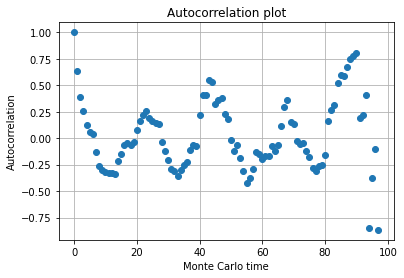

In [25]:
plt.title("Autocorrelation plot")
plt.plot(np.arange(len(conf_ac)), ac_hist, 'C0o')
plt.xlabel("Monte Carlo time")
plt.ylabel("Autocorrelation")
plt.grid("True")

## 2. Monte Carlo simulation

In [26]:
nt = 32

nt      = 32         #  number of temperature points
N       = 10         #  size of the lattice, N x N
eqSteps = 1      #  number of MC sweeps for equilibration
mcSteps = 100       #  number of MC sweeps for calculation


T       = np.linspace(1.53, 3.28, nt); 
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 

In [28]:
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
ensem = []
M_err = []

for tt in range(nt):
    conf = []
    
    E1 = M1 = E2 = M2 = 0
    iT=1.0/T[tt]; iT2=iT*iT;
    
    ising = lgt.Lattice([N,N])
    ising.init_fields('Ising2d','Cold')        # initialise
    bare_parameters = ising.bare_parameter_generator()
    bare_parameters['beta'] = iT

    
    for i in range(eqSteps):         # equilibrate
        lgt.metropolis(ising,bare_parameters)

    M_hist = []
    for i in range(mcSteps):
        
        lgt.metropolis(ising,bare_parameters)
        
        conf.append(ising.field)
        Ene = calcEnergy(ising.field)     # calculate the energy
        Mag = calcMag(ising.field)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M_hist.append(Mag)
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene
    
    ensem.append(conf)


    # divide by number of sites and iteractions to obtain intensive values    
    E[tt] = n1*E1
    M[tt] = n1*M1
    M_err.append(np.std(M_hist)/100.)
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

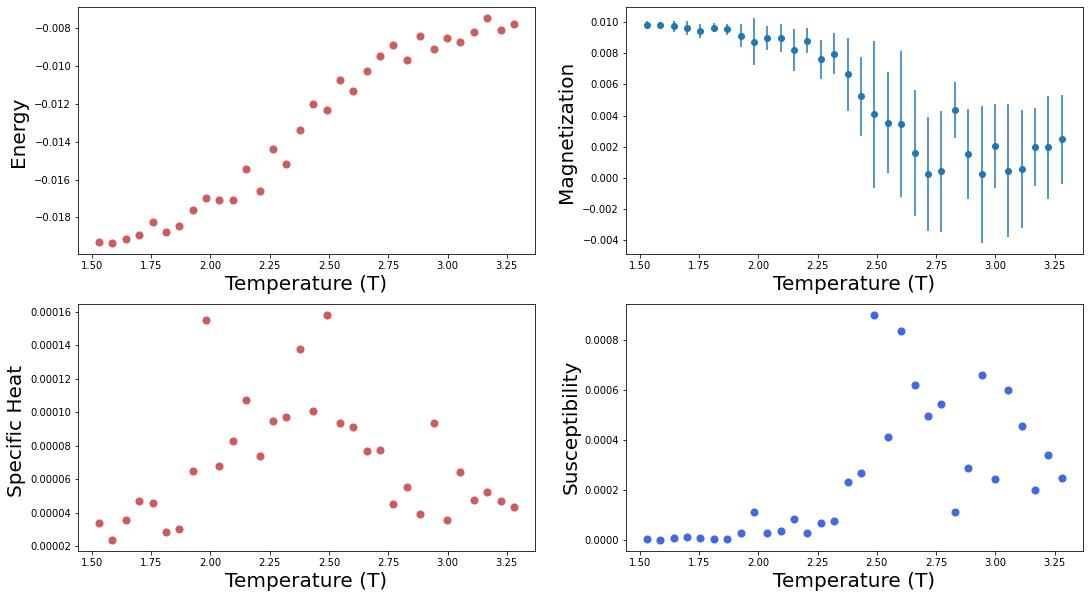

In [29]:
#  plot the calculated values   
#----------------------------------------------------------------------

f = plt.figure(figsize=(18, 10)); #  


sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');


sp =  f.add_subplot(2, 2, 2 );
# plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.errorbar(T, abs(M), yerr=M_err, fmt='C0o')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');

In [46]:
# S_list = []
# for i in range(100):
#     S_list.append(G.S(conf[i]))

In [47]:
# plt.hist(S_list, bins=20)

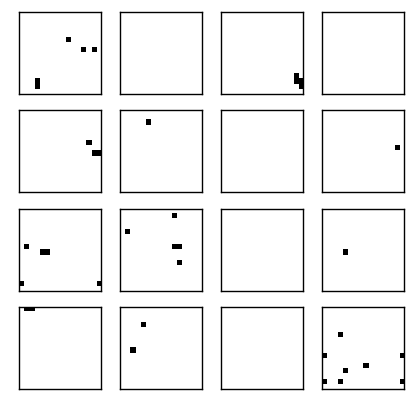

In [48]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(conf[ind*10], vmin=-1, vmax=1, cmap='gray')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
    
plt.show()

In [49]:
# Measure
M = []
for i in range(len(conf)):
    M.append(calcMag(conf[i]))

In [50]:
np.fabs(np.mean(M))

0.9834375

In [61]:
np.std(M)

0.0

In [62]:
len(conf)

1000

In [63]:
conf_name = 'Ising_b%0.3fN%d' %(bare_parameters['beta'],N)
print(conf_name)
np.save(conf_name+'.npy', conf)

Ising_b0.654N16


In [2]:
import numpy as np
a = np.zeros(3)